## Importing needed packages

In [763]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm

## Defining Input Data

In [764]:
# Create a dataframe for Capacity Cost
CapCost = pd.DataFrame({
    'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
    'CapCost[€/MW]': [150, 100, 2500, 9000, 9000]
})

# Create a dataframe for Operating Cost
OpCost = pd.DataFrame({
    'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
    'OpCost[€/MWh]': [200, 250, 500, 0, 0]
})

# Create a dataframe to define general technology information
TechInfo = pd.DataFrame({
    'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
    'Type': ['Fossil', 'Fossil', 'Fossil', 'RES', 'RES']
})

# Create a dataframe for Storage Cost
StorCost = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'StorCost[€/MWh]': [10, 50000000]
})

# Create a dataframe for Capacity Limit
CapLim = pd.DataFrame({
    'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
    'CapLim[MW]': [100000, 100000, 100000, 10000000, 10000000]
})

# Create a dataframe for existing capacity
CapExi = pd.DataFrame({
    'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
    'ExCap[MW]': [100, 50, 50, 100, 100]
})

# Create a dataframe for outphased capacity
CapOut = pd.DataFrame({
    'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
    'OutCap[MW]': [0, 0, 0, -50, 0]
})


# Create a dataframe for demand on hourly basis
Demand = pd.DataFrame({
    'Hour': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    'Demand[MWh]': [500,60,555,343,644,343,535,223,535,634,90,535,223,535,634,343,535,223,535,634,943,535,223,535]
})

# Create a dataframe for eta charge
EtaCh = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'EtaCh': [0.9, 0.8]
})

# Create a dataframe for eta discharge
EtaDis = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'EtaDis': [0.9, 0.8]
})

# Create a dataframe for existing storage capacity
StorExi = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'ExStor[MWh]': [40, 0]
})


## Data Sampling

In [765]:
# Given single time series for Wind and Solar (1 row, 24 hours each)
ProdFacWind = np.array([[  
    0.07149117259925315, 0.20690652911053053, 0.17089549294945167, 0.18881997277064186, 
    0.20005366722911527, 0.36282711876056234, 0.4851625621195393, 0.609154052662755, 
    0.6635074058672907, 0.8744552242877893, 0.7799802294571636, 0.8414978281203519, 
    0.9364414827427749, 0.9645481320075096, 0.9312765663817734, 0.7834986690899264, 
    0.6829013245988148, 0.5967793277038156, 0.4073780665068157, 0.33104623367164343, 
    0.33071882539854985, 0.24498913233631167, 0.1011445772753432, 0.13822843349204414
]])

ProdFacSolar = np.array([[  
    0.003151111598444441, 0.007907054051593435, 0.01831563888873418, 0.039163895098987066, 
    0.07730474044329971, 0.14085842092104503, 0.23692775868212176, 0.3678794411714424, 
    0.5272924240430484, 0.697676326071031, 0.521437889662112, 0.9607894391523233, 
    1.0, 0.9607894391523233, 0.521437889662112, 0.697676326071031, 
    0.272924240430484, 0.3678794411714424, 0.23692775868212176, 0.14085842092104503, 
    0.07730474044329971, 0.039163895098987066, 0.01831563888873418, 0.007907054051593435
]])

# Transpose to correct format (Hours × 1 Scenario)
ProdFacWind = ProdFacWind.T  # Shape: (24, 1)
ProdFacSolar = ProdFacSolar.T  # Shape: (24, 1)

# Number of new scenarios to generate
num_scenarios = 100
num_hours = 24  # 24-hour period

# Step 1: Fit Normal Distributions for Each Hour (Using Small Variability)
wind_distributions = {}
solar_distributions = {}

for hour in range(num_hours):
    # Wind
    wind_mean = ProdFacWind[hour, 0]
    wind_std_dev = max(0.15 * wind_mean, 0.05)  # 5% of mean, at least 0.01
    wind_distributions[hour] = (wind_mean, wind_std_dev)

    # Solar
    solar_mean = ProdFacSolar[hour, 0]
    solar_std_dev = max(0.05 * solar_mean, 0.01)  # 5% of mean, at least 0.01
    solar_distributions[hour] = (solar_mean, solar_std_dev)

# Step 2: Generate New Scenarios Using Monte Carlo Sampling
wind_scenarios = np.zeros((num_hours, num_scenarios))
solar_scenarios = np.zeros((num_hours, num_scenarios))

for scenario in range(num_scenarios):
    for hour in range(num_hours):
        # Wind Sampling
        wind_mean, wind_std_dev = wind_distributions[hour]
        wind_sample = np.random.normal(wind_mean, wind_std_dev)
        wind_scenarios[hour, scenario] = np.clip(wind_sample, 0, 1)

        # Solar Sampling
        solar_mean, solar_std_dev = solar_distributions[hour]
        solar_sample = np.random.normal(solar_mean, solar_std_dev)
        solar_scenarios[hour, scenario] = np.clip(solar_sample, 0, 1)

## Defining Input Parameters

In [766]:
# Define number of hours as length of demand
N_Hours = len(Demand)

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = wind_scenarios.shape[1]


# Define epsilon
epsilon = 0.1

#Define delta
delta = 0.9

BigM = 1000000

## Defining classes

In [767]:
# Class for external input data
class InputData():
    def __init__(self, CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Dem,EtaCha,EtaDis,StorExi, WindScen, SolarScen):
        self.CapCost = CapCost
        self.OpCost = OpCost
        self.TechInfo = TechInfo
        self.StorCost = StorCost
        self.CapLim = CapLim
        self.CapExi = CapExi
        self.CapOut = CapOut
        self.Dem = Dem
        self.EtaCha = EtaCha
        self.EtaDis = EtaDis
        self.StorExi = StorExi
        self.WindScen = WindScen
        self.SolarScen = SolarScen

        

In [768]:
# Class for model parameters
class Parameters():
    def __init__(self, epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM):
        self.epsilon = epsilon
        self.delta = delta
        self.N_Hours = N_Hours
        self.N_Cap = N_Cap
        self.N_Stor = N_Stor
        self.N_Scen = N_Scen
        self.BigM = BigM

## Creating Data and Parameter Objects

In [769]:
ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM)
DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Demand,EtaCh,EtaDis,StorExi, wind_scenarios, solar_scenarios)


## Creating the Model

In [770]:
# CLASS WHICH CAN HAVE ATTRIBUTES SET

class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [771]:
# Defining the optimization model class

class CapacityProblem():
    def __init__(self, ParametersObj, DataObj, Model_results = 1, Guroby_results = 1):
        self.P = ParametersObj # Parameters
        self.D = DataObj # Data
        self.Model_results = Model_results
        self.Guroby_results = Guroby_results
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        # Create the variables
        self.var.CapNew = self.m.addMVar((self.P.N_Cap), lb=0)  # New Capacity for each type of generator technology
        self.var.EGen = self.m.addMVar((self.P.N_Cap, self.P.N_Hours, self.P.N_Scen), lb=0)  # Energy Production for each type of generator technology for each hour and scenario
        self.var.CapStor = self.m.addMVar((self.P.N_Stor), lb=0)  # New storage capacity for each type of storage technology
        self.var.SOC = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # State of charge for each type of storage technology for each hour and scenario  
        self.var.EChar = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # Energy charged for each type of storage technology for each hour and scenario
        self.var.EDis = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # Energy discharged for each type of storage technology for each hour and scenario
        self.var.u = self.m.addMVar((self.P.N_Scen), vtype=GRB.BINARY) # Binary variable for each scenario  # Chance for each scenario


    def _build_constraints(self):
        # Limit new capacity by maximum investable capacity for each type of generator technology
        for g in range(self.P.N_Cap):
            self.con.CapLim = self.m.addConstr(self.var.CapNew[g] <= self.D.CapLim['CapLim[MW]'][g], name=f'Capacitylimit G_{g}')
        
        # Production limited by sum of new capacity, existing capacity and phased out capacity times the production factor
        for g in range(self.P.N_Cap):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    if self.D.TechInfo['Plant'][g] == 'Wind':
                         self.con.ProdLim = self.m.addConstr(self.var.EGen[g, h,s] <= (self.var.CapNew[g] + self.D.CapExi['ExCap[MW]'][g] + self.D.CapOut['OutCap[MW]'][g]) * self.D.WindScen[h,s], name=f'Production limit wind G_{g} H_{h} S_{s}')
                    elif self.D.TechInfo['Plant'][g] == 'Solar':
                         self.con.ProdLim = self.m.addConstr(self.var.EGen[g, h,s] <= (self.var.CapNew[g] + self.D.CapExi['ExCap[MW]'][g] + self.D.CapOut['OutCap[MW]'][g]) * self.D.SolarScen[h,s], name=f'Production limit solar G_{g} H_{h} S_{s}')
                    else:
                        self.con.ProdLim = self.m.addConstr(self.var.EGen[g, h,s] <= self.var.CapNew[g] + self.D.CapExi['ExCap[MW]'][g] + self.D.CapOut['OutCap[MW]'][g], name=f'Production limit convent G_{g} H_{h} S_{s}')
                        


        # Energy Balance constraint - generation and discharge needs to equal demand and charging for each hour and scenario
        for h in range(self.P.N_Hours):
            for s in range(self.P.N_Scen):
                self.con.Balance = self.m.addConstr(gp.quicksum(self.var.EGen[:, h,s]) + gp.quicksum(self.var.EDis[:, h,s]) == self.D.Dem['Demand[MWh]'][h] + gp.quicksum(self.var.EChar[:, h,s]), name=f'Energy balance H_{h} S_{s}')

        # Defining RES share as a percentage of total energy demand
        for s in range(self.P.N_Scen):
            self.con.RESShare = self.m.addConstr(self.P.delta * gp.quicksum(self.D.Dem['Demand[MWh]'][h] for h in range(self.P.N_Hours)) - gp.quicksum(self.var.EGen[g, h,s] for h in range(self.P.N_Hours) for g in range(self.P.N_Cap) if self.D.TechInfo['Type'][g] == 'RES' )  <= self.P.BigM * (1 - self.var.u[s]), name=f'RES share S_{s}')

        # Defining how many scenarios are allowed to be violated
        self.con.ScenViol = self.m.addConstr(gp.quicksum(self.var.u[s] for s in range(self.P.N_Scen))/self.P.N_Scen >= (1- self.P.epsilon), name=f'Scenario violation')


        # Defining SOC as SOC from previous hour plus energy charged minus energy discharged for each hour and scenario
        for u in range(self.P.N_Stor):
            for h in range(1, self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.SOC = self.m.addConstr(self.var.SOC[u, h,s] == self.var.SOC[u, h-1,s] + self.var.EChar[u, h-1,s] - self.var.EDis[u, h-1,s], name=f'State of charge U_{u} H_{h} S_{s}')

        # Define SOC for first hour
        for u in range(self.P.N_Stor):
            for s in range(self.P.N_Scen):
                self.con.SOC0 = self.m.addConstr(self.var.SOC[u, 0,s] == (self.D.StorExi['ExStor[MWh]'][u])*0, name=f'State of charge 0 U_{u} S_{s}')

        # Limit SOC by maximum storage capacity for each type of storage technology
        for u in range(self.P.N_Stor):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.SOCLim = self.m.addConstr(self.var.SOC[u, h,s] <= self.var.CapStor[u] + self.D.StorExi['ExStor[MWh]'][u], name=f'Storage capacity limit U_{u} H_{h} S_{s}')

        # Limit charged energy by capacity minus state of charge for each hour and scenario
        for u in range(self.P.N_Stor):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.ECharLim = self.m.addConstr(self.var.EChar[u, h,s] <= self.var.CapStor[u] + self.D.StorExi['ExStor[MWh]'][u] - self.var.SOC[u, h,s], name=f'Energy charged limit U_{u} H_{h} S_{s}')

        # Limit discharged energy by state of charge for each hour and scenario
        for u in range(self.P.N_Stor):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.EDisLim = self.m.addConstr(self.var.EDis[u, h,s] <= self.var.SOC[u, h,s], name=f'Energy discharged limit U_{u} H_{h} S_{s}')


        
    
    def _build_objective(self):
        # Objective function
        objective = (gp.quicksum(self.var.CapNew[g] * self.D.CapCost['CapCost[€/MW]'][g] for g in range(self.P.N_Cap))  # Cost for new capacity for each type of generator technology
        + gp.quicksum(self.var.EGen[g,h,s] * self.D.OpCost['OpCost[€/MWh]'][g] for g in range(self.P.N_Cap) for h in range(self.P.N_Hours) for s in range(self.P.N_Scen)) # Operating cost for each type of generator technology for each hour and scenario
        + gp.quicksum(self.var.CapStor[u] * self.D.StorCost['StorCost[€/MWh]'][u] for u in range(self.P.N_Stor))) # Cost for new storage capacity for each type of storage technology
        self.m.setObjective(objective, GRB.MINIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)

    
    def _build_model(self):
        self.m = gp.Model('CapacityProblem')
        self._build_variables()
        self._build_constraints()
        self._build_objective()
        self._display_guropby_results()
        self.m.write("CapacityProblem.lp")
        self.m.optimize()
        self._results()
        if self.Model_results == 1:
            self._extract_results()
            

    
    def _results(self):
        self.res.obj = self.m.objVal
        self.res.CapNew = self.var.CapNew.X
        self.res.EGen = self.var.EGen.X
        self.res.CapStor = self.var.CapStor.X
        self.res.SOC = self.var.SOC.X
        self.res.EChar = self.var.EChar.X
        self.res.EDis = self.var.EDis.X
        self.res.u = self.var.u.X
         
        
        #Create Dataframe for new capacity
        self.res.CapNew = pd.DataFrame({
            'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
            'CapNew[MW]': self.res.CapNew,
            'CapExi[MW]': self.D.CapExi['ExCap[MW]'],
            'CapOut[MW]': self.D.CapOut['OutCap[MW]']
        })

        #Create Dataframe for new storage capacity
        self.res.CapStor = pd.DataFrame({
            'Plant': ['Battery', 'Pumped Hydro'],
            'CapStor[MWh]': self.res.CapStor
        })

        # Create DataFrame for scenario violations
        self.res.Violation_Scenarios = pd.DataFrame({
            'Scenario': list(range(self.P.N_Scen)),
            'Violated (1=No, 0=Yes)': self.res.u
        })
        
        
    

        # self.res.EGen_Scenarios = {}

        # for s in range(self.P.N_Scen):
        #     # Extract data for scenario `s`
        #     e_gen_scenario = self.res.EGen[:, :, s].T  # Transpose to match (Hours x Generators)
        #     soc_scenario = self.res.SOC[:, :, s].T  # (Hours x Storage Technologies)
        #     echar_scenario = self.res.EChar[:, :, s].T  # (Hours x Storage Technologies)
        #     edis_scenario = self.res.EDis[:, :, s].T  # (Hours x Storage Technologies)

        #     # Extract Wind and Solar Production Factors
        #     wind_prod_factor = self.D.WindScen[:, s]  # Extract Wind Production Factor for scenario `s`
        #     solar_prod_factor = self.D.SolarScen[:, s]  # Extract Solar Production Factor for scenario `s`

        #     # Convert to DataFrames
        #     df_scenario = pd.DataFrame(e_gen_scenario, columns=['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'])
        #     df_soc = pd.DataFrame(soc_scenario, columns=['Battery_SOC', 'PumpedHydro_SOC'])
        #     df_echar = pd.DataFrame(echar_scenario, columns=['Battery_Charge', 'PumpedHydro_Charge'])
        #     df_edis = pd.DataFrame(edis_scenario, columns=['Battery_Discharge', 'PumpedHydro_Discharge'])
        #     df_demand = pd.DataFrame({'Demand': self.D.Dem['Demand[MWh]']})

        #     # Add Wind & Solar Production Factors
        #     df_prod_factors = pd.DataFrame({'Wind_ProdFactor': wind_prod_factor, 'Solar_ProdFactor': solar_prod_factor})

        #     # Add Hour column
        #     df_scenario['Hour'] = list(range(self.P.N_Hours))

        #     # Merge all DataFrames
        #     df_complete = pd.concat([df_scenario, df_soc, df_echar, df_edis, df_demand, df_prod_factors], axis=1)

        #     # Reorder columns
        #     df_complete = df_complete[['Hour', 'Coal', 'Gas', 'Nuclear', 'Wind', 'Solar',
        #                             'Battery_SOC', 'PumpedHydro_SOC',
        #                             'Battery_Charge', 'PumpedHydro_Charge',
        #                             'Battery_Discharge', 'PumpedHydro_Discharge',
        #                             'Demand', 'Wind_ProdFactor', 'Solar_ProdFactor']]

        #     # Store in dictionary
        #     self.res.EGen_Scenarios[f"Scenario_{s}"] = df_complete
    

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        # Display the new capacity for each type of generator technology
        print('New capacity for each type of generator technology: ', self.res.CapNew)
        
        #Display new storage capacity for each type of storage technology
        print('New storage capacity for each type of storage technology: ', self.res.CapStor)

        

## Execute the model

In [772]:
CapacityProblem = CapacityProblem(ParametersObj, DataObj)
#CapacityProblem._results()
#CapacityProblem._extract_results()

ResultsCapacity = CapacityProblem.res.CapNew
ResultsStorage = CapacityProblem.res.CapStor
ResultsViolations = CapacityProblem.res.Violation_Scenarios

# for scenario_name, df in CapacityProblem.res.EGen_Scenarios.items():
#     df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
#     print(f"Saved {scenario_name}.csv")

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 33706 rows, 26507 columns and 102705 nonzeros
Model fingerprint: 0x08f7b877
Variable types: 26407 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+06]
  Objective range  [1e+01, 5e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 1e+07]
Presolve removed 1105 rows and 700 columns
Presolve time: 0.17s
Presolved: 32601 rows, 25807 columns, 99800 nonzeros
Variable types: 25707 continuous, 100 integer (100 binary)

Root relaxation: objective 2.690530e+07, 16028 iterations, 0.36 seconds (0.30 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0      

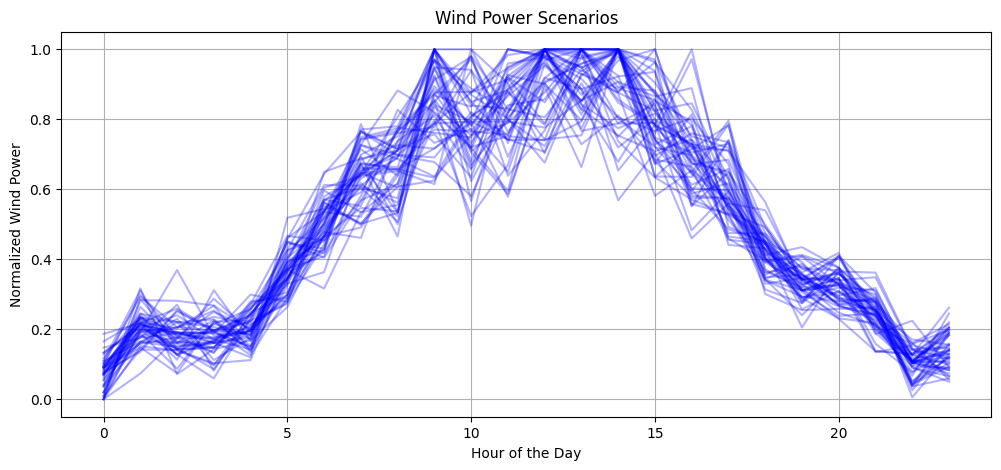

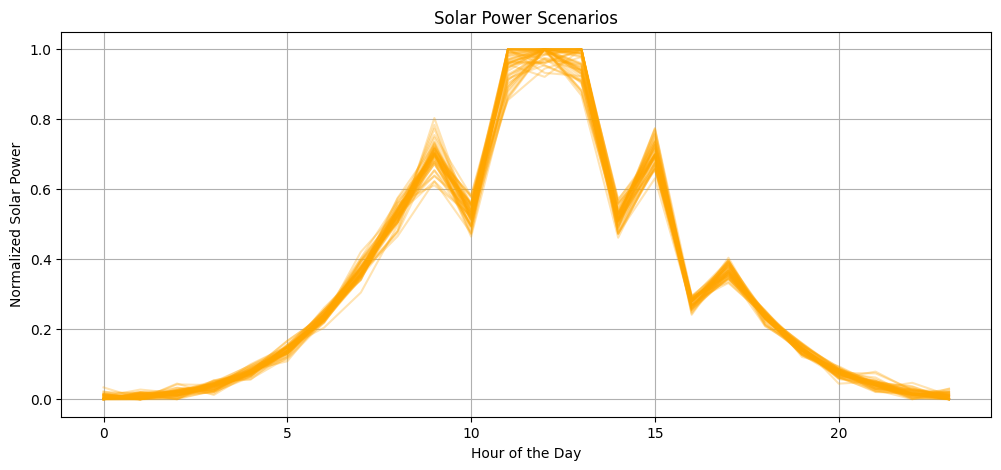

In [773]:
import matplotlib.pyplot as plt

# Plot Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(50):  # Plot only first 50 scenarios for clarity
    plt.plot(range(num_hours), wind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(50):  # Plot only first 50 scenarios for clarity
    plt.plot(range(num_hours), solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()
